<div align="right">This exercise was carried out on my own PC Python 3.5 Jupyter Notebook</div>

# Geotagging WiFi access points

<div class="alert alert-warning">
**This notebook contains advanced exercises that are only applicable to students who wish to deepen their understanding and qualify for bonus marks on this course.** You will be able to achieve 100% for this notebook by successfully completing exercise 1. An optional, additional exercise can be completed to qualify for bonus marks.
</div>

### Your completion of the notebook exercises will be graded based on your ability to do the following: 

**All students**:

> **Evaluate**: Are you able to interpret the results and justify your interpretation based on the observed data?


**Advanced students**:

> **Apply**: Are you able to execute code (using the supplied examples) that performs the required functionality on supplied or generated data sets? 

> **Analyze**: Are you able to pick the relevant method or library to resolve specific stated questions?

> **Create**: Are you able to produce notebooks that serve as computational record of a session, and can be used to share your insights with others? 

#### Notebook objectives
By the end of this notebook you will be expected to understand and apply the steps involved in geotagging, which are the following:
> 1. Match the records in time.
2. Compute the median location of each access point (AP).
3. Filter out the non-stationary routers.
 
####  List of exercises
>   - **Exercise 1**: Identification of stationary WiFi routers.
  - **Exercise 2 [Advanced]**: Identification of non-stationary WiFi routers.

# Notebook introduction

This notebook will use the same Dartmouth StudentLife data set, as in previous exercises. In this exercise, you will combine WiFi scans with location information to create a small database of WiFi access point (AP) locations, using Google's location services. You will be replicating the work of Piotr Sapieżyński et al. (2015).

You will start by importing the necessary modules and variable definitions.

<div class="alert alert-warning">
<b>Note</b>:<br>
It is strongly recommended that you save and checkpoint after applying significant changes or completing exercises. This allows you to return the notebook to a previous state should you wish to do so. On the Jupyter menu, select "File", then "Save and Checkpoint" from the dropdown menu that appears.
</div>

#### Load libraries and set options

In order to compute the median and calculate the distances in Section 1.4.2, you will need to import the custom function from the "utils” directory.

In [1]:
# Load relevant libraries.
from os import path
import pandas as pd
import numpy as np
import folium
import glob
from tqdm import tqdm
%matplotlib inline

# Load custom modules.
import sys
sys.path.append('..')
from utils import getmedian, haversine
from utils import llaToECEF as coords_to_geomedian
from utils import ECEFTolla as geomedian_to_coords

from IPython.display import Image

In [2]:
# Define variable definitions.
wifi_path     = 'data/dartmouth/wifi'
location_path = 'data/dartmouth/location/'

## 1. Single user review
For simplicity, review a single user's data, examine the properties of that data, and try to see if analysis yields any results of value. You should be familiar with both WiFi and location data, from previous exercises. As a result, they will be loaded and presented without extensive clarification.

#### 1.1 Data exploration

In [3]:
# Load WiFi data.
u00_wifi = pd.read_csv(path.join(wifi_path, 'wifi_u00.csv')) 
u00_wifi.head(3)

,time,BSSID,freq,level
0,1364356963,00:60:b3:07:1d:27,2427,-90
1,1364356963,f8:1e:df:fd:4a:4b,2417,-64
2,1364358163,f8:1e:df:fd:4a:4b,2417,-69


In [4]:
# Load location data.
u00_loc = pd.read_csv(path.join(location_path, 'gps_u00.csv'))
u00_loc.head(3)

,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate
0,1364356963,network,wifi,24.0,43.759135,-72.329240,0.000000,0.0,0.0,stationary
1,1364358144,gps,NaN,22.0,43.759503,-72.329018,250.899994,0.0,0.0,NaN
2,1364359364,network,wifi,23.0,43.759134,-72.329238,0.000000,0.0,0.0,stationary


#### 1.2 Remove the columns that you do not require

In [5]:
# Remove columns from WiFi dataset.
u00_wifi.drop(['freq', 'level'], axis=1, inplace=True)
u00_wifi.head(3)

,time,BSSID
0,1364356963,00:60:b3:07:1d:27
1,1364356963,f8:1e:df:fd:4a:4b
2,1364358163,f8:1e:df:fd:4a:4b


In [6]:
# Remove columns from location dataset.
u00_loc.drop(['provider', 'network_type', 'bearing', 'speed', 'travelstate'], axis=1, inplace=True)
u00_loc.head(3)

,time,accuracy,latitude,longitude,altitude
0,1364356963,24.0,43.759135,-72.329240,0.000000
1,1364358144,22.0,43.759503,-72.329018,250.899994
2,1364359364,23.0,43.759134,-72.329238,0.000000


#### 1.3 Remove location records with poor accuracy
The accuracy reported in location records is interpreted counterintuitively. The higher the value, the less accurate the measurement. It denotes the radius of a circle within which 68% of the measurements (or one standard deviation) of the reported coordinates are present. Since the radius of an outdoor access point can reach 250 metres  (Sapiezynski et al. 2015), it is safe to assume a more conservative measure of 200 metres (at an elevated risk of classifying routers as non-stationary).

The accuracy of location measurements is a major source of noise, hence the need for additional consideration. To do that,  you need to plot the cumulative distribution of the accuracy.

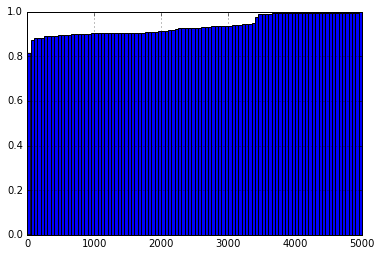

In [7]:
# Plot histogram of accuracy observations.
u00_loc.accuracy.hist(cumulative=True, normed=1, bins=100)

It looks like the data set contains quite accurate location measurements, as a visual inspection of the histogram suggests that almost 90% of the observations have relatively good accuracy. It is therefore safe to select only the most accurate observations.

Using the Pandas "describe" function, you can get a quick view of the data set.

In [8]:
# Review the dataset with Pandas decribe function.
u00_loc.accuracy.describe()

count    4316.000000
mean      341.247721
std       948.196821
min         3.000000
25%        22.000000
50%        30.000000
75%        40.500000
max      5000.000000
Name: accuracy, dtype: float64

Next, determine how many observations to keep. The impact of using an accuracy value of 40 is demonstrated in the cell below.

In [9]:
# Determine the number of records meeting our threshold of 40 for accuracy.
result = len(u00_loc[u00_loc.accuracy <= 40]) / float(len(u00_loc))
print('Proportion of records that meet the criteria is {:.1f}%'.format(100*result))

Proportion of records that meet the criteria is 73.2%


73% of the records meet your criteria, and will be used as a filter in subsequent steps.

In [10]:
# Make a copy of the original dataset before applying the filter.
u00_loc_raw = u00_loc.copy()

# Apply the filter.
u00_loc = u00_loc[u00_loc['accuracy'] <= 40]

# Get the lenghts of each of the data objects.
original_location_count = len(u00_loc_raw)
filtered_location_count = len(u00_loc)

print("Number of location observations before filtering: {}".format(original_location_count)) 
print("Number of observations remaining after filtering: {}".format(filtered_location_count))

Number of location observations before filtering: 4316
Number of observations remaining after filtering: 3158


Drop the accuracy column from the DataFrame, as it is no longer required.

In [11]:
# Update the object to remove accuracy.
u00_loc.drop('accuracy', axis=1, inplace=True)

# Display the head of the new dataset.
u00_loc.head(3)

,time,latitude,longitude,altitude
0,1364356963,43.759135,-72.329240,0.000000
1,1364358144,43.759503,-72.329018,250.899994
2,1364359364,43.759134,-72.329238,0.000000


> **Note**:

> For certain methods, Pandas has the option of applying changes to data sets "inplace". While convenient, you will no longer be able to re-execute earlier cells and this feature should be used with care. The guiding principle is that you can use this feature in data cleaning and wrangling steps, where you no longer need to go back and revisit earlier steps.

> Should you need to revisit earlier steps, you can either restart the notebook and execute all the cells up to that point, or only execute the cells needed to get the object in the required form to continue your analysis.

#### 1.4 Geotagging

In order to geotag, location and WiFi readouts need to be matched based on the time of the observations. As in the paper by Sapiezynski et al. (2015),  readouts will be constrained to those happening at exactly the same second, to reduce impact of readouts from moving vehicles.

There are three steps involved in geotagging:
1. Match the records in time.
2. Compute the median location of each AP.
3. Filter out the non-stationary routers.

These three steps will be explored in further detail in the following sections of this notebook.

#### 1.4.1 Match the records 
This requires the use of Pandas magic to join (much like SQL's join) the DataFrames based on time. First, use the time as the index with the "`df.set_index()`" method, and then join them with the "`df.join()`" method.

In [12]:
# Set the index for WiFi.
u00_wifi = u00_wifi.set_index('time')
u00_wifi.head(3)

,BSSID
time,
1364356963,00:60:b3:07:1d:27
1364356963,f8:1e:df:fd:4a:4b
1364358163,f8:1e:df:fd:4a:4b


In [13]:
# Set the index for location.
u00_loc = u00_loc.set_index('time')
u00_loc.head(3)

,latitude,longitude,altitude
time,,,
1364356963,43.759135,-72.329240,0.000000
1364358144,43.759503,-72.329018,250.899994
1364359364,43.759134,-72.329238,0.000000


Having two DataFrames with time as an index, you can simply "join" them.
> A [JOIN clause](http://pandas.pydata.org/pandas-docs/stable/merging.html) is used to merge DataFrames by combining rows from two or more tables, based on a common field between them. The most common type  of join is an "inner join". An "inner join" between two tables (A and B) returns all rows from A and B, where the join condition is met. That is, the intersection of the two tables.

<img src="innerjoin.png" alt="Drawing" style="width: 800px;"/>

In [14]:
# Join the two data sets and display the head of the new dataset.
u00_raw_geotags = u00_wifi.join(u00_loc, how='inner')
print('{} WiFi records found time matching location records.'.format(len(u00_raw_geotags)))
u00_raw_geotags.head(3)

7493 WiFi records found time matching location records.


,BSSID,latitude,longitude,altitude
time,,,,
1364356963,00:60:b3:07:1d:27,43.759135,-72.329240,0.0
1364356963,f8:1e:df:fd:4a:4b,43.759135,-72.329240,0.0
1364359364,f8:1e:df:fd:4a:4b,43.759134,-72.329238,0.0


It is time to account for possible noise, and remove the routers with sparse data (i.e., less than five observations, as in the referenced paper). Pandas "df.groupby()" will be used to do this.

In [15]:
# Create object u00_groups.
u00_groups = u00_raw_geotags.groupby('BSSID')

# Create a new object where filter criteria is met.
u00_geotags = u00_groups.filter(lambda gr: len(gr)>=5)

print("{} geotagged records remained after trimming for sparse data.".format(len(u00_geotags)))
print("They correspond to {} unique router APs".format(len(u00_groups)))

6256 geotagged records remained after trimming for sparse data.
They correspond to 1048 unique router APs


#### 1.4.2 Compute the median location of each AP
**Define stationary routers** as ones for which 95% of observations fall inside a radius of 200 metres from the geometric median of all of the observations. In order to compute the median and calculate the distances, you will need to import the custom function from the "utils” directory.

In order to compute the geometric medians with the tools at your disposal, the "`getmedian()`" method needs properly-formatted data. That means a lot of list points, where each point is an array of "longitude", "latitude", and "altitude". The algorithm accepts input in degrees as units.

In [16]:
# Create a new DataFrame with latitude and longitude.
u00_geo_medians = pd.DataFrame(columns=[u'latitude', u'longitude'])

# Transform the data set using the provided set of utilities.
for (BSSID, geotags) in u00_groups:
    
    geotags = [row for row in np.array(geotags[['latitude', 'longitude', 'altitude']])]
    geotags = [coords_to_geomedian(row) for row in geotags]
    
    median  = getmedian(geotags)
    median  = geomedian_to_coords(median)[:2]
    
    u00_geo_medians.loc[BSSID] = median

After completing the above, you will have your geomedians, and will be ready to move on to the last step, which is to filter out the non-stationary access points.

In [17]:
# Display the head of the geomedians object.
u00_geo_medians.head(3)

,latitude,longitude
00:01:36:57:be:87,43.706664,-72.287212
00:01:36:57:be:88,43.706641,-72.287126
00:02:2d:9d:ee:5d,38.898938,-77.039681


#### 1.4.3 Filter out the non-stationary routers
**Identify stationary routers** with 95% confidence, and a distance threshold of 200 metres. Start by computing the distances using the "`haversine()`" function.

In [18]:
# Calculate the distances from the median.
u00_distances = {}
for BSSID, geotags in u00_groups:
    u00_distances[BSSID] = []
    (lat_median, lon_median) = u00_geo_medians.loc[BSSID]
    for (lat, lon) in np.array(geotags[['latitude','longitude']]):  
        u00_distances[BSSID].append(haversine(lon, lat, lon_median, lat_median)*1000) # haversine() returns distance in [km]

Now, check how many of the routers pass the threshold. Iterate over the access points, and count the ratio of measurements outside the threshold to all measurements. They are assigned to "static" or "others" based on your confidence level.

In [19]:
# Group access points as static or non-static.
# Set the thresholds.
distance_threshold = 200
confidence_level    = 0.95

# Create empty lists.
static = []
others = []

for BSSID, distances in u00_distances.items():
    
    all_count  = len(distances)
    #for Python 2 to 3, have to use list to return length
    #near_count = len(filter(lambda distance: distance <= distance_threshold, distances))
    near_count = len(list(filter(lambda distance: distance <= distance_threshold, distances)))
    
    if( near_count / all_count >= confidence_level ):
        static.append(BSSID)
    else:
        others.append(BSSID)

# Print summary results.
print ("We identified {} static routers and {} non-static (moved or mobile).".format(len(static), len(others))) 

We identified 1046 static routers and 2 non-static (moved or mobile).


>#### Note: Because I am using Python 3, and adding 'list' to get len, the answer (2 non-static) is different from Python 2.

The tagged routers (access points) can now be visualized on a map.

In [26]:
# Plot the access points on a map.
map_center  = list(u00_geo_medians.median())
routers_map = folium.Map(location=map_center, zoom_start=14)
# Add points to the map for each of the locations.
for router in static:
      folium.CircleMarker(u00_geo_medians.loc[router], fill_color='red', radius=15, fill_opacity=0.5).add_to(routers_map)

#Display the map.
routers_map

> **Note**:

> In order to validate your results, you can perform a "rough" check of validity by using the Google location API, which utilizes their own WiFi positioning. Set "bssid1" and "bssid2" to actual MAC addresses of two routers located near each other to determine the location of a user.

In [27]:
# Import additional library and set access points to review.
import requests
bssid1 = '00:01:36:57:be:88'
bssid2 = '00:01:36:57:be:87'

# Use the Google API to return the geocoded location of the user location.
url = 'https://maps.googleapis.com/maps/api/browserlocation/json?browser=' \
            'chrome&sensor=true&wifi=mac:{}&wifi=mac:{}'.format(bssid1, bssid2)

# Save the response of the API call.
response = requests.post(url)

# Print the response.
print(response.json()['location'])

{'lng': -72.2868704, 'lat': 43.7068263}


You can now compare this to your computed values.

In [28]:
u00_geo_medians.loc[[bssid1, bssid2]]

,latitude,longitude
00:01:36:57:be:88,43.706641,-72.287126
00:01:36:57:be:87,43.706664,-72.287212


The results are acceptable. You can compute the actual distance between the points with the "haversine" function.

In [29]:
# Calculate and display the difference between calculated and Google API provided locations.
lat_m1, lon_m1 = u00_geo_medians.loc[bssid1]
lat_m2, lon_m2 = u00_geo_medians.loc[bssid2]

#lat, lon = response.json()['location'].values()
# Note: Python 3 reverse lat and lon
lon, lat = response.json()['location'].values()

print('Distance from the Google API provided location to our first router ' \
            'estimation is {:2g}m'.format(haversine(lon,lat,lon_m1,lat_m1)*1000))
print('Distance from the Google API provided location to our first router ' \
            'estimation is {:2g}m'.format(haversine(lon,lat,lon_m2,lat_m2)*1000))

Distance from the Google API provided location to our first router estimation is 29.0871m
Distance from the Google API provided location to our first router estimation is 32.8753m


## 2. Review of all users
Next, repeat the analysis from the previous section for all users. This analysis will be used in the next exercise.

<br>
<div class="alert alert-warning">
<b>Important:</b>
Please ensure that this is the only running notebook when performing this section, because you will require as many resources as possible to complete the next section. In the Orientation Module, you were introduced to the process required to shut down notebooks. That being said, you can shut down running notebooks by viewing the "Running" tab on your Jupyter Notebook directory view.
</div>

> **Note**:

> There will be less contextual information provided in this section, as the details have already been provided in Section 1 of this notebook

#### 2.1 Load data for all users
This section utilizes two new libraries that do not fall within the scope of this course. Interested students can read more about [glob](https://docs.python.org/2.7/library/glob.html),  which is used to read files in the specified directory, and [tqdm](https://github.com/tqdm/tqdm), which is  used to render a progress bar. Set your variables, then create the required function to process the input files, and finally, execute this function to process all the files.

> **Note**:

> Processing a large amount of files or records can be time consuming. It is good practice to include progress bars to provide visual feedback where applicable.

In [30]:
# Set variables.
all_geotags = pd.DataFrame(columns=['time','BSSID','latitude','longitude','altitude'])
all_geotags = all_geotags.set_index('time')
pcounter = 0

In [31]:
# Define function to build the dataset, all_geotags, using the input files supplied.
def build_ds(file_in, all_geotags):

    # Get the user id.
    user_id = path.basename(file_in)[5:-4]

    # Read the WiFi and location data for the user.
    wifi = pd.read_csv(file_in)
    loc  = pd.read_csv(path.join(location_path, 'gps_'+user_id+'.csv'))

    # Filter location data not meeting the accuracy threshold.
    loc = loc[loc.accuracy <= 40]

    # Drop the columns not required.
    wifi.drop(['freq', 'level'], axis=1, inplace=True)
    loc.drop(['accuracy', 'provider', 'network_type', 'bearing', 'speed', 'travelstate'], axis=1, inplace=True)

    # Index the datasets based on time.
    loc  = loc.set_index('time')
    wifi = wifi.set_index('time')

    # Join the datasets based on time index.
    raw_tags = wifi.join(loc, how='inner')

    # Return the dataset for the user.
    return [raw_tags]

In [32]:
# Iterate through the files in the specified directory and append the results of the function to the all_geotags variable.
for f in tqdm(glob.glob(wifi_path + '/*.csv')):
    # Append result from our function to all_geotags for each input file supplied.
    all_geotags = all_geotags.append(build_ds(f, all_geotags))

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:30<00:00,  1.41it/s]


#### 2.2 Drop APs with sparse records
Remove access points with less than five observations.

In [33]:
print ("{} all geotags found".format(len(all_geotags)))

all_groups = all_geotags.groupby('BSSID')
print ("{} unique routers found".format(len(all_groups)))

# Drop sparsely populated access points.
all_geotags = all_groups.filter(lambda gr: len(gr)>=5)
all_groups = all_geotags.groupby('BSSID')

print ("{} unique router APs remaining after dropping routers with sparse data".format(len(all_groups)))    

673358 all geotags found
9790 unique routers found
4943 unique router APs remaining after dropping routers with sparse data


#### 2.3 Compute medians
Compute the medians for each router in the combined data set, as per Section 1.4.2.

In [34]:
# Create a new variable containing all the coordinates.
all_geo_medians = pd.DataFrame(columns=[u'latitude', u'longitude'])

# Compute the geomedians and add to all_geo_medians.

# Initiate progress bar.
with tqdm(total=len(all_groups)) as pbar:
    # Iterate through data in all_groups as per single user example.
    for i, data in enumerate(all_groups):
        (BSSID, geotags) = data

        geotags = [row for row in np.array(geotags[['latitude', 'longitude', 'altitude']])]
        geotags = [coords_to_geomedian(row) for row in geotags]

        median  = getmedian(geotags)
        median  = geomedian_to_coords(median)[:2]

        all_geo_medians.loc[BSSID] = median
        pbar.update()
    pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████| 4943/4943 [00:37<00:00, 131.14it/s]


#### 2.4 Compute distances of observations to the calculated median
Compute the distance from the medians for each router in the combined dataset.

In [35]:
# Calculate the distances from the median.
all_distances = {}

# Initiate progress bar.
with tqdm(total=len(all_groups)) as pbar:
    # Iterate through data in all_groups as per single user example.
    for i, data in enumerate(all_groups):
        (BSSID, geotags) = data
        all_distances[BSSID] = []
        (lat_median, lon_median) = all_geo_medians.loc[BSSID]
        for (lat, lon) in np.array(geotags[['latitude','longitude']]):  
            all_distances[BSSID].append(haversine(lon, lat, lon_median, lat_median)*1000)
        pbar.update()
    pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████| 4943/4943 [00:10<00:00, 449.60it/s]


#### 2.5 Label APs as static or non-static

In [36]:
# Group access points as static or non-static.
# Set the thresholds.
distance_threshold = 200
confidence_level   = 0.95

# Create empty lists.
all_static = []
all_others = []

for BSSID, distances in all_distances.items():
    
    all_count  = len(distances)
    #for Python 2 to 3, have to use list to return length
    #near_count = len(filter(lambda distance: distance <= distance_threshold, distances))
    near_count = len(list(filter(lambda distance: distance <= distance_threshold, distances)))
    
    if( near_count / all_count >= confidence_level ):
        all_static.append(BSSID)
    else:
        all_others.append(BSSID)

# Print summary results.
print ("We identified {} static routers and {} non-static (moved or mobile).".format(len(all_static), len(all_others))) 

We identified 4762 static routers and 181 non-static (moved or mobile).


#### 2.6 Plot the static APs

In [38]:
# Plot the access points on a map.
all_map_center  = list(all_geo_medians.median())
all_routers_map = folium.Map(location=all_map_center, zoom_start=2)
# Add points to the map for each of the locations.
for router in all_static:
      folium.CircleMarker(all_geo_medians.loc[router], fill_color='red', radius=15, fill_opacity=0.5).add_to(all_routers_map)

#Display the map.
all_routers_map

<br>
<div class="alert alert-info">
<b>Exercise 1 Start.</b>
</div>

### Instructions

> Review the visual output produced for all users. Try to find a static router located outside North America. Remember that you can scroll and zoom on the map.

>**Question**: Are you able to locate a static router located outside North America? If so, where? 

Your markdown answer here.

### Static router is located in the UK, just outside city of London, at Midland St, St Pancreas International Station.
>#### To be precise, the location is: latitude:45.434977; longitude:12.338865; and altitude:43.599998

>* I want to locate that 'renegade' router more precisely from the dataset
>* Quick way is to find a record where the longitude is an outlier and close to London's published location of 51N 0.12W
>* I will look for the min and max values of 'longitude' as a first shot

In [39]:
u00_raw_geotags['longitude'].min()

-77.05533890000001

In [40]:
u00_raw_geotags['longitude'].max()

12.338864539999999

In [41]:
# Bingo! longitude 12.33 is the suspect. I will next look at a few max longitude row records to validate
df1 = u00_raw_geotags.ix[u00_raw_geotags['longitude'].idxmax()]
df1.head(5)

,BSSID,latitude,longitude,altitude
time,,,,
1367878494,00:1d:8b:41:80:80,45.434977,12.338865,43.599998
1367878494,00:1d:8b:57:d4:c4,45.434977,12.338865,43.599998
1367878494,00:24:89:c2:22:4c,45.434977,12.338865,43.599998
1367878494,00:27:22:44:3f:31,45.434977,12.338865,43.599998
1367878494,08:76:ff:c0:3b:8c,45.434977,12.338865,43.599998


In [42]:
#Now to print the precise UK router location...
print ("The precise location of the UK static router is: latitude:{:,.6f}; longitude:{:,.6f}; and altitude:{:,.6f} \
       ".format(df1.iloc[0,1],df1.iloc[0,2],df1.iloc[0,3])) 

The precise location of the UK static router is: latitude:45.434977; longitude:12.338865; and altitude:43.599998        


<br>
<div class="alert alert-info">
<b>Exercise 1 End.</b>
</div>
> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

<br>
<div class="alert alert-info">
<b>Exercise 2 [Advanced] Start.</b>
</div>

> <div class="alert alert-warning">
<b>Note</b>:<br>
This activity is for advanced students only and extra credit will be allocated. Students will not be penalized for not completing this activity.
</div>

### Instructions

> Can you identify moving BSSIDs and plot the observed locations on a map?

> This is not a trivial task (compared to geotagging stationary routers) and there are many possible ways to perform the analysis.

> Input : All data points for an access point. 

> Output: Boolean mobility status.  
    
> 1. Perform agglomerative clustering. (This is not covered in the scope of this course.)
> 2. Discard clusters with n<5 observations as noise.
> 3. Compare pairwise timeframes in which each of the clusters were observed. 
> 4. If at least two clusters overlap (in time), consider the AP as mobile.
    
> **Note**:

> Keep in mind that other, possibly better, solutions exist, and you are encouraged to provide your input.

> **Hints**:

> You can start by reviewing [SciPy](https://www.scipy.org/).

> - `from scipy.spatial.distance import pdist`

> - `from scipy.cluster.hierarchy import linkage, fcluster`

In [43]:
# Your answer here.
#  Please add as many cells as you require in this section.

### Here is my plan of attack..
>1. Load data for all users as per section 2 above
>2. Do some EDA to view and familiarise with the summary statistics
>3. Create a condensed distance matrix using pdist function
>4. Run linkage function to create a hierarchical tree and check cophenet coefficient for fit
>5. Plot a dendogram for visualisation and run inconsistency test
>6. Use Elbow Method to determine cluster cutoff point
>7. Retrieve clusters with fcluster function
>8. Finally, plot the Mifi locations on a map

### 1. Import the needed libraries and load data

In [45]:
# needed imports
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet, inconsistent

In [46]:
# Reuse the filtered out non-static routers (all_others) from previous step
mifi_all = all_geotags[all_geotags.BSSID.isin(all_others)]

In [47]:
mifi_all.head(3)

,BSSID,latitude,longitude,altitude
time,,,,
1364386963,36:a9:05:12:34:f9,43.706725,-72.287296,0.0
1364388163,36:a9:05:12:34:f9,43.706725,-72.287344,0.0
1364391763,36:a9:05:12:34:f9,43.706713,-72.287329,0.0


### 2. Do some EDA to view and familiarise with the summary statistics

In [48]:
# validate that there are 181 non-static APs as established in previous section
mifi_all.BSSID.describe()

count                  8572
unique                  181
top       36:a9:05:11:71:69
freq                   3285
Name: BSSID, dtype: object

In [49]:
# do a values_count to choose a target BSSID with not so many data points, cos the later algorithms can chew up 
# memory and cpu resources :-)
pd.value_counts(mifi_all['BSSID']).head()

36:a9:05:11:71:69    3285
36:a9:05:12:34:f9    1963
d0:57:4c:08:76:40     198
18:33:9d:71:e7:c5     155
1a:a8:6d:52:af:06     107
Name: BSSID, dtype: int64

In [50]:
# I selected the BSSID with 198 points - should be a nice number to show dendogram, etc.
# keeping my fingers crossed that the non-stationarity feature of the data will show up!
mifi = mifi_all[mifi_all.BSSID == 'd0:57:4c:08:76:40']
mifi.head()

,BSSID,latitude,longitude,altitude
time,,,,
1364600927,d0:57:4c:08:76:40,43.706596,-72.287053,0.0
1365800866,d0:57:4c:08:76:40,43.706628,-72.287345,0.0
1364667397,d0:57:4c:08:76:40,43.706580,-72.287026,0.0
1364933797,d0:57:4c:08:76:40,43.706593,-72.287019,0.0
1364934997,d0:57:4c:08:76:40,43.706593,-72.287019,0.0


In [52]:
# Just having a feel of the target data set summary stats
mifi.describe()

,latitude,longitude,altitude
count,198.000000,198.000000,198.0
mean,43.706467,-72.287581,0.0
std,0.000573,0.002197,0.0
min,43.702741,-72.297062,0.0
25%,43.706596,-72.287068,0.0
50%,43.706608,-72.287050,0.0
75%,43.706617,-72.287030,0.0
max,43.706724,-72.286983,0.0


In [53]:
# I need to make a np.array for later use
mifi_arr = np.array(mifi[['latitude','longitude']])
mifi_arr[:10,0:2]

array([[ 43.706596 , -72.287053 ],
       [ 43.7066278, -72.2873446],
       [ 43.7065803, -72.2870259],
       [ 43.7065926, -72.2870186],
       [ 43.7065935, -72.2870193],
       [ 43.7065829, -72.2870166],
       [ 43.7065777, -72.2869899],
       [ 43.7065765, -72.2870176],
       [ 43.7065881, -72.2870218],
       [ 43.7066306, -72.2870205]])

In [54]:
# Quick check the data is all there
print (mifi_arr.shape)

(198, 2)


### 3. Create a condensed distance matrix using pdist function

>* I am sticking with Euclidean geometry for the pdist, since the Dartmouth data is like on a small-scale geographical area, and should be a good approximation. 
>* The haversine distance will give better accuracy when the scale is large, like across a continent.

In [55]:
# I will do a scipy pdist, using default euclidean distance
mifi_pdist = pdist(mifi_arr)
mifi_pdist

array([  2.93328826e-04,   3.13193231e-05,   3.45676149e-05, ...,
         1.79367026e-04,   2.22185081e-04,   4.36953087e-05])

In [56]:
# Testing out a squareform to see if there is any later use
squareform(mifi_pdist)

array([[  0.00000000e+00,   2.93328826e-04,   3.13193231e-05, ...,
          2.75200890e-04,   9.61353213e-05,   5.30667504e-05],
       [  2.93328826e-04,   0.00000000e+00,   3.22220328e-04, ...,
          8.23337719e-05,   2.00601595e-04,   2.43589244e-04],
       [  3.13193231e-05,   3.22220328e-04,   0.00000000e+00, ...,
          3.06272379e-04,   1.26998031e-04,   8.43000593e-05],
       ..., 
       [  2.75200890e-04,   8.23337719e-05,   3.06272379e-04, ...,
          0.00000000e+00,   1.79367026e-04,   2.22185081e-04],
       [  9.61353213e-05,   2.00601595e-04,   1.26998031e-04, ...,
          1.79367026e-04,   0.00000000e+00,   4.36953087e-05],
       [  5.30667504e-05,   2.43589244e-04,   8.43000593e-05, ...,
          2.22185081e-04,   4.36953087e-05,   0.00000000e+00]])

### 4. Run linkage function to create a hierarchical tree and check cophenet coefficient for fit

>* Now the plot thickens... I am going to run a scipy linkage, using default euclidean distance, and method = 'complete'.
>* The 'complete' method link the furthest neighbour, and is good for cluster circle type data, like in this use case
>* If the cluster data is expected to be more spectrum or chain, then 'single' method (linking nearest neighbor) will be cool.

In [57]:
# Run linkage
mifi_link=linkage(mifi_pdist,method='complete')

>* I will verify any dissimilarity by using the cophenet function to compare the hierarchical cluster tree with original data and compute their correlation, returning a value called the cophenetic correlation coefficient. 
>* The closer the value of the cophenetic correlation coefficient is to 1, the more accurately the clustering solution reflects your data.

In [58]:
# I will now do the cophenet test to verify dissimilarity
c, coph_dist = cophenet(mifi_link,mifi_pdist)
c

0.99962080607073522

>* Wow! How much better can it get?

### 5. Plot a dendogram for visualisation and run inconsistency test

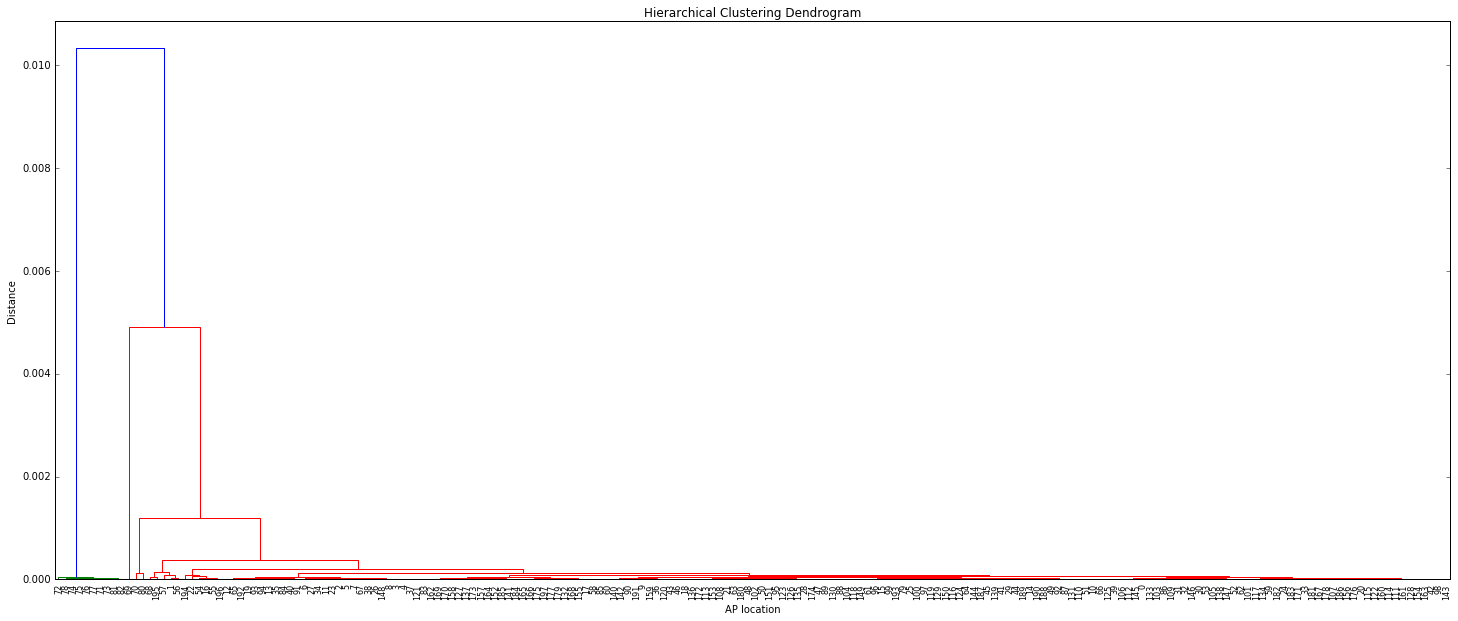

In [59]:
# Next, I will calculate and plot a dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('AP location')
plt.ylabel('Distance')
dendrogram(
    mifi_link,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

>* The dendogram visualisation is expected, since the target BSSID data selected is from a non-static pool, which means there is going to be some clusters with big distances.
>* One way to vaidate this is to do a consistency test - the clusters are said to be inconsistent when some links (the blue one) is way higher distance from other cluster links below.
>* The relative consistency of each link in a hierarchical cluster tree can be quantified and expressed as the inconsistency
coefficient. This value compares the height of a link in a cluster hierarchy with the average height of links below it. Links
that join distinct clusters have a high inconsistency coefficient; links that join indistinct clusters have a low inconsistency
coefficient.

In [60]:
# Run a inconsistent function test
mifi_incon = inconsistent (mifi_link)

In [61]:
# Check data
mifi_incon[-5:]

array([[  1.37712514e-04,   6.57666341e-05,   3.00000000e+00,
          1.09317408e+00],
       [  2.41653019e-04,   1.24333152e-04,   3.00000000e+00,
          1.10364173e+00],
       [  5.61698371e-04,   5.56983640e-04,   3.00000000e+00,
          1.12286677e+00],
       [  3.04685194e-03,   2.63006267e-03,   2.00000000e+00,
          7.07106781e-01],
       [  5.09753266e-03,   5.14269865e-03,   3.00000000e+00,
          1.01804762e+00]])

>* The inconsistency coefficient is in column 4. [col 1= mean; col 2 = std; col 3= number of links in the calculation]
>* Lots of zero values, cos they are leaf nodes.
>* Cursory look indicated some high coefficients in the 8 to 9 mark
>* I think there will some good distinct clusters showing up when I start to create the clusters

### 6. Use Elbow Method to determine cluster cutoff point

>* Now, what method shall I use to create the clusters. I could use: a natural cutoff method using a inconsistent coefficient observed previously, or I could use a method to specify an arbitrary number of clusters I want, etc.
>* Apparently, there is no golden method to pick the number of clusters. Wikipedia lists a couple of common
method - but I think in the end it is a bit about being investigative and manaully backtesting. 
>* However, I want to first try a cool elbow method that may visually show me a good cutoff point to create my MiFi clusters.

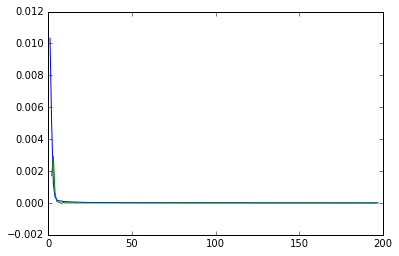

recommended number of clusters is: 4


In [66]:
# Testing out the elbow method..
last = mifi_link [:,2]
last_rev=last[::-1]
idxs=np.arange(1,len(last)+1)
plt.plot(idxs,last_rev)
accel=np.diff(last,2)

# 2nd derivative of the distances
accel_rev=accel[::-1]
plt.plot(idxs[:-2]+1,accel_rev)
plt.show()
k=accel_rev.argmax()+3
# if idx 0 is the max of this, we want 3 clusters
print ('recommended number of clusters is:',k)

### 7. Retrieve clusters with fcluster function

In [79]:
# Now that I have a k-value, I can retrive the clusters with fcluster function
k = 4
clusters=fcluster(mifi_link,k,criterion='maxclust')
clusters[0:7]

array([3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [80]:
# merge the dataframes containing cluster id and geolocation data
dfc = pd.DataFrame({'clust_id':clusters})
mifi2 = mifi.reset_index()
dfm = pd.merge(mifi2,dfc,right_index='True',left_index='True')

In [75]:
# Summarise data down to just the cluster locations
dff = dfm.groupby('clust_id').agg({'latitude':[np.mean],'longitude':[np.mean]})
dff.head()

,longitude,latitude
,mean,mean
clust_id,,
1,-72.297032,43.704321
2,-72.287828,43.705839
3,-72.287055,43.706610
4,-72.289995,43.702741


In [81]:
# Covert the merged dfs to became an array that is needed by folium 
mifi_arr2 = np.array(dff[['latitude','longitude']])
mifi_arr2

array([[ 43.7043209 , -72.29703236],
       [ 43.7058392 , -72.28782795],
       [ 43.7066101 , -72.28705466],
       [ 43.7027411 , -72.289995  ]])

### 8. Finally, plot the Mifi locations on a map

In [78]:
mifi_center  = list(all_geo_medians.median())
mifi_map = folium.Map(location=mifi_center, zoom_start=14)

for coord in mifi_arr2:
    folium.CircleMarker(location=[coord[0],coord[1]],fill_color='#43d9de', radius=60).add_to(mifi_map)
    
mifi_map

>* The plot shows that the access point is not stationary
>* For the duration of the data collected, the access point has moved at least 4 locations, as determined by cluster analysis.
>* The access point could be on a bus, or a MiFi, or it could be a mobile phone WiFi hotspot. 

<br>
<div class="alert alert-info">
<b>Exercise 2 [Advanced] End.</b>
</div>
> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

> It is strongly recommended that you select "Close and Halt" when you have completed this notebook, to ensure that it does not continue to consume available resources.

## 3. Submit your notebook

Please make sure that you:
- Perform a final "Save and Checkpoint";
- Download a copy of the notebook in ".ipynb" format to your local machine using "File", "Download as", and "IPython Notebook (.ipynb)"; and
- Submit a copy of this file to the Online Campus.

## 4. References
Sapieżyński, Piotr, Radu Gatej, Alan Mislove, and Sune Lehmann. 2015. “Opportunities and Challenges in Crowdsourced Wardriving.” Proceedings of the 2015 ACM Conference on Internet Measurement Conference.